# MI-term: $\mathbb{E}_{\Theta \sim p(\Theta \vert X_{1:n})} \left[\mathcal{H}[\tilde{Y}_{1:n} \vert \Theta, X_{1:n}] \right]$

In [1]:
from math import isclose, log, log2
from scipy.stats import norm, bernoulli
import numpy as np
import matplotlib.pyplot as plt

def h(p):
    # Set h = 0 in the limit p -> 0, and p -> 1
    entropy = np.empty(p.shape)
    one_lim = np.isclose(p, 1.0)
    zero_lim = np.isclose(p, 0.0)
    limit_inds = np.logical_or(one_lim, zero_lim)
    entropy[limit_inds] = 0
    # For the rest, compute it the usual way.
    ok_inds = np.logical_not(limit_inds)
    ok_p = p[ok_inds]
    entropy[ok_inds] = -ok_p*np.log2(ok_p) - (1-ok_p)*np.log2(1-ok_p)
    return entropy

def h_(p):
    # Set h = 0 in the limit p -> 0, and p -> 1
    if isclose(p, 1.0) or isclose(p, 0.0):
        entropy = 0
    else:
    # For the rest, compute it the usual way.
        entropy = -p*np.log2(p) - (1-p)*np.log2(1-p)
    return entropy

def h_arr(p_arr):
    return np.array([h_(p) for p in p_arr])

def p(z, alpha_i=0.9):
    """Likelihood p(Ỹ_i = ỹ_i | Theta = theta, X_i = x_i),
    with z = theta^T x_i
    """
    return (2*alpha_i - 1)*norm.cdf(z) + 1-alpha_i

def mc_approx(x, alpha, num_terms=100):
    theta_samples = norm.rvs(size=num_terms)
    z = x * theta_samples
    probit_val = norm.cdf(z)
    #print(probit_val.max())
    entropies = h(p(z, alpha))
    return entropies.mean()

## Taylor approximation of $ln(h((2\alpha_i - 1)\Phi(\theta x_i) + 1 - \alpha_i))$
This is the same approx. as in BALD, with the added $\alpha_i$ label noise.
Results in a poor fit as the approximation goes to zero in the extremes, even in the presence of label noise.

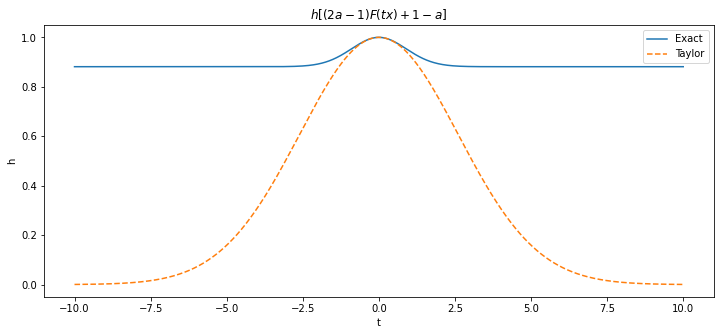

In [2]:
plt.rcParams['figure.figsize'] = (12,5)
def analytical(x, theta, alpha):
    return h(p(x*theta, alpha))

def taylor_approx(x, theta, alpha):
    """Taylor approximation of ln(h(p(theta, x)))"""
    return np.exp(- (2 * alpha - 1)**2 / (np.pi * np.log(2)) * (theta*x)**2)

thetas = np.linspace(-10, 10, 1000)
fig, ax = plt.subplots()
x = 1
alpha = 0.7
ax.plot(thetas, analytical(thetas, x, alpha), label="Exact")
ax.plot(thetas, taylor_approx(thetas, x, alpha), '--', label="Taylor")
ax.set_title("$h[(2a -1)F(t x) + 1 - a]$")
ax.set_xlabel("t")
ax.set_ylabel("h")
ax.legend();

## Taylor approximation of difference $ln(h((2\alpha_i - 1)\Phi(\theta x_i) + 1 - \alpha_i) - h(\alpha_i))$

Let $h(...) = h(...) - h(\alpha_i) + h(\alpha_i)$ and only approximate the first two terms.
The result is an entropy approx. that decays to $h(\alpha_i)$ in the extremes and gives BALD-like quality of fit for every label precision $\alpha_i$

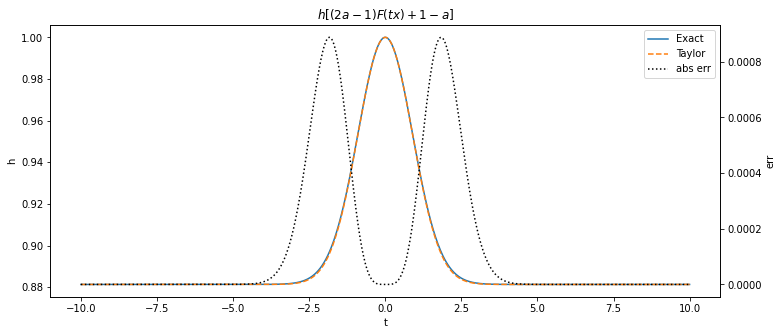

In [3]:
def taylor_approx(x, theta, alpha):
    """Taylor approximation of ln(h(p(theta, x)))"""
    if np.isclose(alpha, 0.5):
        return np.ones(x.shape)
    alpha_entropy = h(np.atleast_1d(alpha)).item()
    constant_term = np.log(1 - alpha_entropy)
    factor_1 = 1 / (1 - alpha_entropy)
    factor_2 = - (2 * alpha - 1)**2 / (np.pi * np.log(2)) * (theta*x)**2
    return np.exp(constant_term + factor_1*factor_2) + alpha_entropy

thetas = np.linspace(-10, 10, 1000)
x = 1.0
alpha = 0.7
analytical_h = analytical(thetas, x, alpha)
taylor_h = taylor_approx(thetas, x, alpha)

fig, ax_1 = plt.subplots()
analytical_l = ax_1.plot(thetas, analytical_h, label="Exact")
taylor_l = ax_1.plot(thetas, taylor_h, "--", label="Taylor")
ax_1.set_title("$h[(2a -1)F(t x) + 1 - a]$")
ax_1.set_xlabel("t")
ax_1.set_ylabel("h")
ax_2 = ax_1.twinx()
abs_err_l = ax_2.plot(thetas, np.abs(analytical_h - taylor_h), linestyle="dotted", color="black",label="abs err")
ax_2.set_ylabel("err")
lns = analytical_l + taylor_l + abs_err_l
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc=0);

# MI-term: $\mathcal{H}[\tilde{Y}_{1:n} \vert X_{1:n}]$

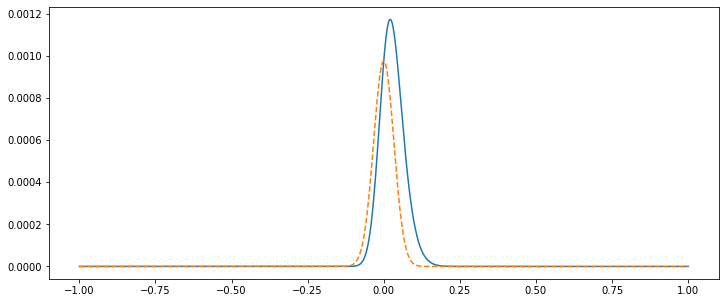

In [4]:
def p_y_tilde_seq_theta(y_tilde_seq, x_seq, theta, alpha_seq):
    """Likelihood p(Ỹ_1:n = ỹ_1:n | Theta = theta, X_1:n = x_1:n)
    
    Args:
        y_tilde_seq (np.array): Seq. of Bernoulli variables (n,): {0, 1}^n
        x_seq (np.array): Seq. of np.arrays (n, D_x)
        theta (np.array): Vector (D_x,)
        alpha_seq (np.array): Seq of prec. values (n,): [0.5, 1]^n
        
    """
    true_inds = y_tilde_seq == 1
    false_inds = y_tilde_seq == 0
    z = theta @ x_seq.T
    true_prod = p(z[true_inds], alpha_seq[true_inds])
    false_prod = 1 - p(z[false_inds], alpha_seq[false_inds])
    return true_prod.prod() * false_prod.prod()

def p_y_tilde_seq_taylor(y_tilde_seq, x_seq, theta, alpha_seq):
    """Approximate likelihood p_hat(Ỹ_1:n = ỹ_1:n | Theta = theta, X_1:n = x_1:n)
    
    Args:
        y_tilde_seq (np.array): Seq. of Bernoulli variables (n,): {0, 1}^n
        x_seq (np.array): Seq. of np.arrays (n, D_x)
        theta (np.array): Vector (D_x,)
        alpha_seq (np.array): Seq of prec. values (n,): [0.5, 1]^n
        
    """
    n = y_tilde_seq.shape[0]
    constant_term = n * np.log(2)
    inv_cov = (alpha_seq * x_seq.T) @ x_seq / np.pi
    quad_term = theta.T @ inv_cov @ theta
    return np.exp(-(constant_term + quad_term))
    

    
n = 10
D_x = 1
x_seq = np.random.normal(loc=0, scale=10, size=(n, D_x))
y_tilde_seq = bernoulli.rvs(p=0.5, size=n)
# y_tilde_seq = bernoulli.rvs(p=norm.cdf(x_seq).reshape((n,)))
thetas = np.atleast_2d(np.linspace(-1, 1, 1000)).T
exact_ps = [p_y_tilde_seq_theta(y_tilde_seq, x_seq, theta, np.ones((n,))) for theta in thetas]
taylor_ps = [p_y_tilde_seq_taylor(y_tilde_seq, x_seq, theta, np.ones((n,))) for theta in thetas]

fig, ax_1 = plt.subplots()
exact_l = ax_1.plot(thetas, exact_ps, label="Exact")
taylor_l = ax_1.plot(thetas, taylor_ps, "--", label="Taylor")



(1000,)

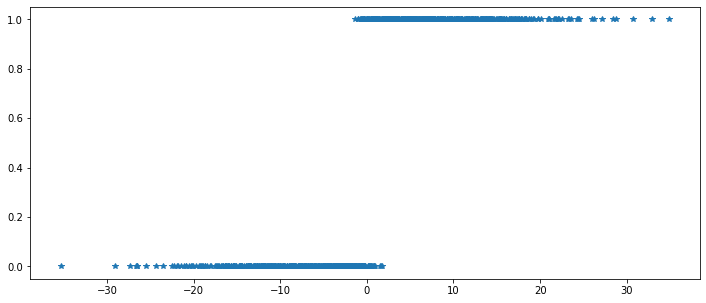

In [5]:
n = 1000
x_seq = np.random.normal(loc=0, scale=10, size=(n, D_x))
y_tilde_seq = bernoulli.rvs(p=norm.cdf(x_seq).reshape((n,)))
fig, ax = plt.subplots()
ax.plot(x_seq, y_tilde_seq, "*")
#y_tilde_seq = bernoulli.rvs(p=0.5, size=n)
y_tilde_seq.shape

In [6]:
def multi_analytical(theta, y_tildes, xs, alphas):
    trues = y_tildes == 1
    falses = y_tildes == 0
    true_terms = np.log(p(xs[trues] * theta, alphas[trues]))
    false_terms = np.log(1 - p(xs[falses] * theta, alphas[falses]))
    return np.exp(true_terms.sum() + false_terms.sum())

def multi_taylor_approx(theta, y_tildes, xs, alphas):
    """Taylor approximation of ln(h(p(theta, x)))"""
    trues = y_tildes == 1
    falses = y_tildes == 0
    true_terms = ( alphas[trues] - 1 )**2 * xs[trues]**2
    false_terms = (1 - p(xs[falses] * theta, alphas[falses]))
    inv_cov = 
    return np.exp(- (2 * alpha - 1)**2 / (np.pi * np.log(2)) * (theta*x)**2)

num_samples = 10
y_tildes = bernoulli.rvs(p=0.5, size=num_samples)
xs = norm.rvs(size=num_samples)
alphas = np.ones(xs.shape)
thetas = np.linspace(-10, 10, 1000)
entropies = np.array([multi_analytical(theta, y_tildes, xs, alphas) for theta in thetas])

fig, ax = plt.subplots()
ax.plot(thetas, entropies, label="Exact")
# ax.plot(thetas, taylor_approx(thetas, x, alpha), '--', label="Taylor")
ax.set_title("$h[(2a -1)F(t x) + 1 - a]$")
ax.set_xlabel("t")
ax.set_ylabel("h")
ax.legend();

SyntaxError: invalid syntax (2563257139.py, line 14)